## Importing Libraries:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt

import warnings
import time
import pickle
import json

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import recall_score, precision_score, roc_auc_score, fbeta_score, accuracy_score, \
                            classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, \
                            precision_recall_curve, mean_squared_error, r2_score, make_scorer, average_precision_score

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

from scipy.stats import randint

## Importing Data:

In [2]:
X_test_preprocessed = np.load("../Data/Transformed_X_test.npy")

y_test = pd.read_csv("../Data/y_test.csv").squeeze("columns")
y_test.head()

,Unnamed: 0,Target_Variable_Convert
0,71787,0
1,67218,0
2,54066,0
3,7168,0
4,29618,0


In [3]:
# Making sure that the index of the y_test dataset is the same as in the previous notebook for the sake of continuity
y_test.set_index("Unnamed: 0", inplace = True)
y_test = y_test["Target_Variable_Convert"]
y_test[:10]

Unnamed: 0
71787     0
67218     0
54066     0
7168      0
29618     0
101425    0
20441     0
2662      0
20371     0
108151    0
Name: Target_Variable_Convert, dtype: int64

## Importing Model:

In [4]:
with open("../Models/Ada_Boost_Model.pkl", "rb") as ada_boost_model:
    final_clf = pickle.load(ada_boost_model)

## Question 6 - 
### Step 1: Checking Robustness of Results with Different Metrics:
#### Confusion Matrix:

In [5]:
y_pred = final_clf.predict(X_test_preprocessed)
y_pred[:10]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 1])

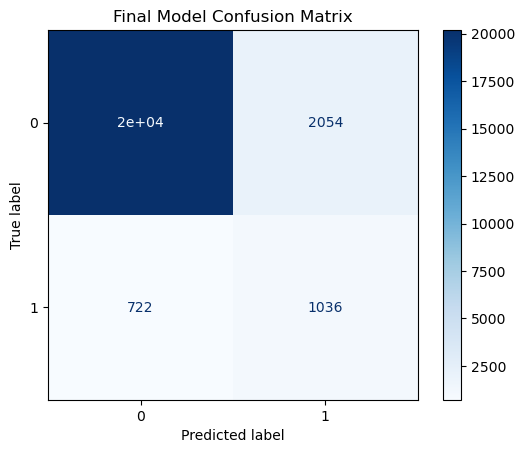

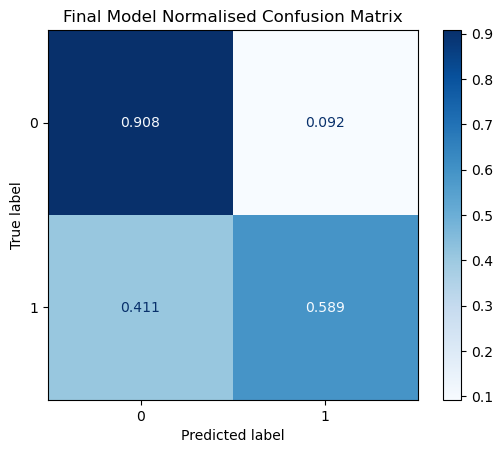

In [6]:
conf_matrix = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix = conf_matrix)
disp.plot(cmap = "Blues")
plt.title("Final Model Confusion Matrix")
plt.show()

normalised_matrix = conf_matrix.astype(float) / conf_matrix.sum(axis = 1)[:, np.newaxis]

norm_disp = ConfusionMatrixDisplay(confusion_matrix = normalised_matrix)
norm_disp.plot(cmap = "Blues", values_format = ".3f")
plt.title("Final Model Normalised Confusion Matrix")
plt.show()

The confusion matrices seen above show us very important information. While the absolute number of instances of Class 1 that were predicted correctly might seem very low at only 942, especially when compared to the 21287 instances of Class 0 that were predicted correctly, that small number accounts for 53.6% of all the Class 1 instances in the Test dataset, a significant percentage when considering the extent to which the dataset was imbalanced between the two target variable classes. Nevertheless, assuming more time is provided, this percentage should be looked at once again and improved further in order to maximise the True Positive instances and minimise the amount of False Negative instances the model predicts. 

#### ROC Curve (Receiver Operating Characteristic Curve):

In [7]:
# The left column of numbers represents the probability of an instance being classified as "Class 0" while the right column
# of numbers represents the probability of an instance being classified as "Class 1" by the classification model
y_prob = final_clf.predict_proba(X_test_preprocessed)
y_prob[:9]

array([[0.48663784, 0.51336216],
       [0.50905302, 0.49094698],
       [0.506915  , 0.493085  ],
       [0.55766573, 0.44233427],
       [0.51112304, 0.48887696],
       [0.57560141, 0.42439859],
       [0.51831478, 0.48168522],
       [0.50624727, 0.49375273],
       [0.51877619, 0.48122381]])

In [8]:
y_pred[:9]

array([1, 0, 0, 0, 0, 0, 0, 0, 0])

In [9]:
# Isolating the right column of numbers representing the probabilities given to instances to be classified as "Class 1"
TRUE_prob = y_prob[:, 1]
TRUE_prob

array([0.51336216, 0.49094698, 0.493085  , ..., 0.43474858, 0.48306841,
       0.46503573])

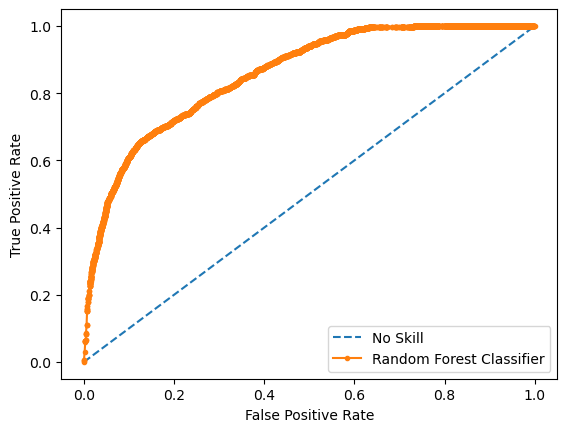

In [10]:
# Calculating the ROC Curve for the final model
fpr, tpr, thresholds = roc_curve(y_test, TRUE_prob)

plt.plot([0,1], [0,1], linestyle = '--', label = 'No Skill')
plt.plot(fpr, tpr, marker = '.', label = 'Random Forest Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

The diagram above visualises another metric which helps put into perspective the performance of the Random Forest Classifier model. The x-axis of the diagram (The False Positive Rate) refers to the percentage of instances incorrectly predicted to be of "Class 1" while the y-axis of the diagram (The True Positive Rate) refers to the percentage of instances correctly predicted to be of "Class 1". As such, the greater the aread under the curve (AUC), the higher the performance of the diagram because the higher the percentage of instances correctly identified as "Class 1" and the lower the percentage of instances incorrectly identified as "Class 1". 

The dotted blue line represents the performance of a hypothetical model which classified instances as "Class 0" or "Class 1" in a completely random manner, while the orange curve represents the performance of the Random Forest Classifier model itself. The AUC score itself can reach a maximum score of 1.0 and minimum score of 0.0, however, realistically, because the AUC score of the fotted blue line (which represents a simulation of a random classification model) is equal to 0.5, AUC scores for models realistically vary between 0.5 and 1.0 (any model with an AUC score of less than 0.5 will be scrapped for a simpler random classification model). As seen in the output of the cell below, the AUC score of the model developed for this project is equal to 0.877, which is a relatively acceptable score. The score itself means that the model has an 87.7% chance of correctly differenciating between the two classes of the target variable. While an AUC score of 0.877 might not be high enough to be implemented in certain sensitive sectors of the economy without being improved, it's can be an acceptable performance depending on the situation.

In [11]:
# Calculating the Area Under the Curve (AUC) for the ROC curve:
auc_rf = roc_auc_score(y_test, TRUE_prob)

print(f"AUC for Random Forest Classifier: {auc_rf:.3f}")

AUC for Random Forest Classifier: 0.856


In [12]:
# Calculating the Gini Coefficient:
gini = 2 * auc_rf -1
gini

0.711641843537409

The Gini Coefficient ranges from -1.0 to 1.0. On one hand, a Gini score equal to 1.0 indicates that the model distinguishes completely accurately between both classes of the target variable. On the other hand, a Gini score equal to 0.0 would be the resulting score for a random prediction model that is unable to distinguish between either class (assuming that the dataset is balanced). A Gini Coefficient of 0.754 is not especially incredible, however, considering how imbalanced the dataset is, the Gini score becomes more acceptable, indicating that the model is significantly better than an alternative random prediction model. 

#### PRC Curve (Precision-Recall Curve):

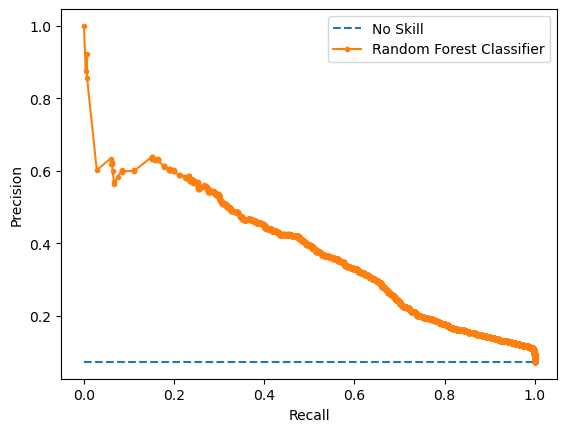

In [13]:
# Obteniendo todos los parámetros necesarios para ilustrar un gráfico de PRC:
precision, recall, thresholds = precision_recall_curve(y_test, TRUE_prob)
denominator = precision + recall

no_skill = len(y_test[y_test == 1]) / len(y_test)
plt.plot([0,1], [no_skill, no_skill], linestyle = '--', label = 'No Skill')
plt.plot(recall, precision, marker = '.', label = 'Random Forest Classifier')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

We can see the AUC of the PRC curve below. This metric suggests that the model's performance is not especially impressive seeing as the AUC-PR score ranges from 0.0 to 1.0, and that a simulated classification model trained with balanced classes will be able to achieve an AUC-PR score equal to 0.5, which is higher than the score seen below of 0.479. However, the data being used for this project has a significantly imbalanced target variable with 7.3% of instances belonging to "Class 1" and 92.7% belonging to "Class 0". As such, the AUC-PR score of a random classification model trained with this imbalanced data would have resulted in an AUC-PR score of 0.073. Taking this information into account, we can see that the AUC-PR score for the resulting model is actually not as bad as it seemed at first. 

In [14]:
auc_pr = average_precision_score(y_test, TRUE_prob)
auc_pr

0.38524433716729956

#### Cumulative Gains Curve:

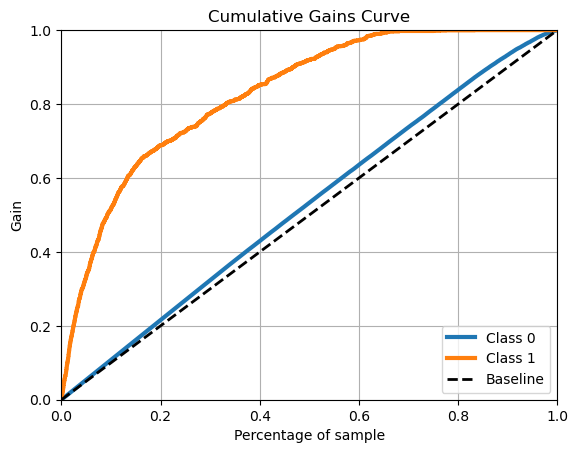

In [15]:
skplt.metrics.plot_cumulative_gain(y_test, y_prob)
plt.title("Cumulative Gains Curve")
plt.show()

The orange cumulative gains curve above represents the percentage of learning that the model is able to obtain with a given percentage of the training sample having been analysed. Its interesting to see that the model already reaches 100% of all the learning it will ever reach with regards to the statistical patterns assigned to instances of "Class 1" with only about 70% of the training sample being analysed. This is a relatively good result which shows that the preprocessing of the training dataframe was done sufficiently well for the model to interpret all the patterns of "Class 1" in a timely manner. 

The blue cumulative gains curve represents the same information as the orange curve, except for the fact that it analyses the instances of "Class 0" instead of those of "Class 1" like the orange curve does. It's very interesting and surprising that the blue curve appears lower than the orange curve, and that the diagram suggests that the model learns the patters from the instances of "Class 0" significantly slower than those of the instances of "Class 1". The surprising aspect of this difference is that instances of "Class 0" significantly outnumber those of "Class 1", which would have theoretically meant that the opposite should have happened. The most likely scenario for why this blue curve is so much lower than the orange curve is that the model likely did not focus on learning the patterns of instances of "Class 0" and instead focused on those of "Class 1", possiibly classifying "Class 0" instances randomly (being mostly accurate simply because the large amount of "Class 0" instances significantly increases the probability of the random guess being right).

#### Lift Curve:

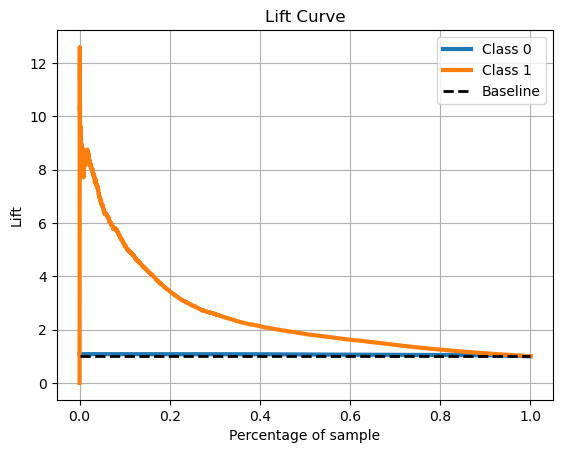

In [16]:
skplt.metrics.plot_lift_curve(y_test, y_prob)
plt.legend(loc='upper right')
plt.show()

The blue and orange Lift curves seen above reflect the improvement of the Random Forest Classifier model compared to that of a random prediction model (represented by the dotted black line at the bottom) as the amount of the training sample is analysed by the model. The part of the diagram that is most important is the difference between either the orange or blue curves and the dotted black curve because this differece represents the difference in learning achieved by the models. Logically, the model learns the fastest when it first starts analysing the training sample, which is why the area between the orange curve and the black dotted line is greates at the beginning and then falls over time (as the improvement in the model's learning decreases as more of the training sample becomes analysed).

The y-axis' Lift score reflects how much more efficient the Random Forest Classifier model is at learning than a simulated random prediction model. As such, we can see that the model developed is significantly more efficient at learning the patters of instances belonging to "Class 1" from the training dataset than the simulated random prediction model, however, in a similar way as the Cumulative Gains Curve seen above, interestingly, the model is not very efficient at learning the patterns of those instances that belong to the "Class 0". This needs to be investigated more in-depth, but I believe it's for the same reason as I already mentioned, that due to the significantly imbalanced dataset, the model focuses on learning patterns for the less common "Class 1" and fails to learn those of the "Class 0" because it's much more likely of being correct when guessing.

### Step 2: Determining Which Accuracy Measure Should be Optimised:

 Como el objetivo de este trabajo 
es predecir la mayor cantidad de cuentas en peligro de abandono posibles, métricas como el F2-Score 
son indispensables, ya que dan pesos más altos a instancias de cuentas abandonadas predichas 
correctamente que a cuentas abiertas predichas correctamente.

To determine which accuracy measure to focus on (choosing between Accuracy, Precision, Recall, F1-Score, F2-Score, etc), it's very important to know the purpose of the project, because a certain client might be more interested in accurately predicting instances of "Class 0" at the expense of those of "Class 1" or vice versa. In this case, while the purpose of the project is unknown, the fact that the dataset is imbalanced implies that the more important class to focus on might be the less common one ("Class 1"). Therefore, it would make more sense to decide that the most relevant accuracy measure is one that emphasizes the accuracy of those predictions at the expense of those for "Class 0". Assuming that this is the case, it would make the most sense to either focus on the Recall or F2-Score metrics because of how they calculate the percentage of "Class 1" instances predicted correctly and how they assign more weight to the correct classification of "Class 1" instances, respectively. For the purpose of this project, I focused on specialising my specific version of a Random Forest Classifier model around the optimisation of the F2-Score metric. This way, I was able to tell the model to focus on predicting as many correct "Class 1" instances as possible even if it ended up being at the expense of correct "Class 0" predictions. 

Similarly, had the dataset had significantly more "Class 1" instances than "Class 0" instances (and the client wished to prioritise the prediction of "Class 0" instances), I would have likely focused on optimising the F0.5-Score metric. Moreover, had the dataset had a perfectly (or close to) balanced target variable, I would have decided to focus on optimising the accuracy metric.

### Step 3: Computing the Feature Importance of the Final Model:

In [23]:
# Importing the list of features from the second notebook
with open("../Data/feature_names.json", 'r') as f:
    feature_names = json.load(f)

In [24]:
# Creating a dataframe to hold all the relative importances of the variables with respect to their names
feature_importance = final_clf.feature_importances_

importance_df = pd.DataFrame({"Feature": feature_names, 
                              "Importance": feature_importance})
importance_df.head()

,Feature,Importance
0,Proj_Group,0.021495
1,Proj_Segment,0.029029
2,Proj_Type,0.031451
3,Visitor_Group,0.200367
4,Visitor_Gender,0.110171


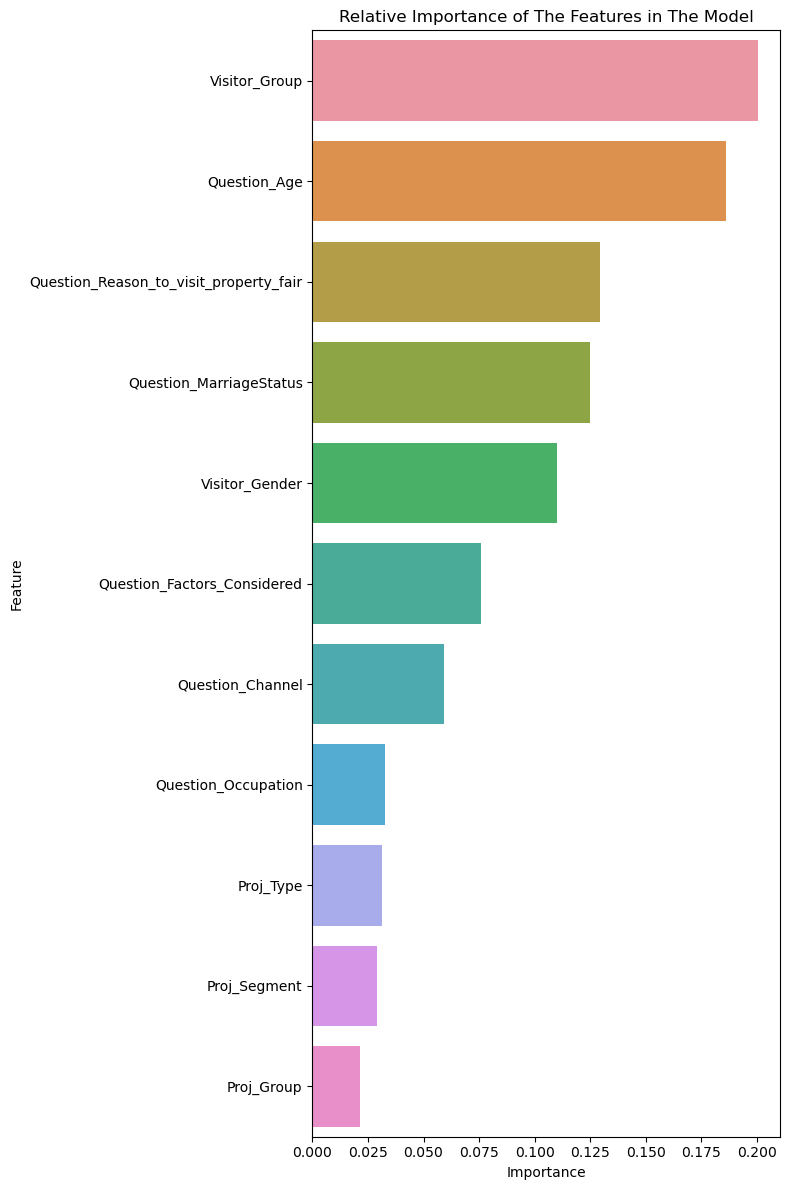

In [25]:
# Illustrating the relative importance of the variables when training the model
importance_df = importance_df.sort_values(by = "Importance", ascending = False)

f, (ax) = plt.subplots(figsize = (8, 12))
sns.barplot(x = "Importance", y = "Feature", data = importance_df, ax = ax)
ax.set_title("Relative Importance of The Features in The Model")
plt.tight_layout()

In [26]:
importance_df.tail(20)

,Feature,Importance
3,Visitor_Group,0.200367
5,Question_Age,0.186005
10,Question_Reason_to_visit_property_fair,0.129348
6,Question_MarriageStatus,0.124789
4,Visitor_Gender,0.110171
9,Question_Factors_Considered,0.075796
8,Question_Channel,0.059087
7,Question_Occupation,0.032461
2,Proj_Type,0.031451
1,Proj_Segment,0.029029
